Shape: (28680, 16)
Columns: ['genres', 'artists', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity', 'key', 'mode', 'count']


,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7
3,[],"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0,1,27
4,[],"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5,1,7



Missing values:
genres              0
artists             0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
popularity          0
key                 0
mode                0
count               0
dtype: int64

Top genres:
main_genre
dance pop                397
adult standards          334
album rock               313
alternative metal        296
latin                    246
contemporary country     221
alternative rock         174
corrido                  170
alternative hip hop      161
classic soul             153
broadway                 140
alternative r&b          135
atl hip hop              134
classical performance    129
alternative dance        127
bebop                    127
brill building pop       120
c-pop                    115
classical                115
funk                     108
Name: count, d

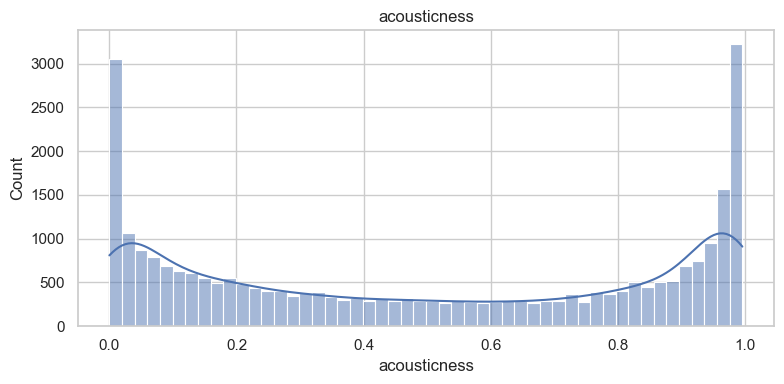

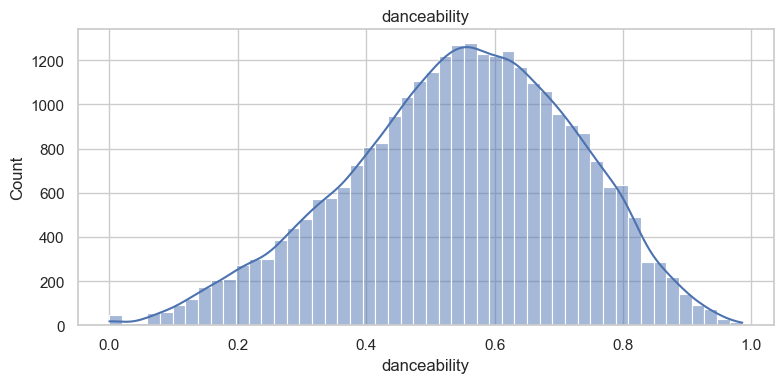

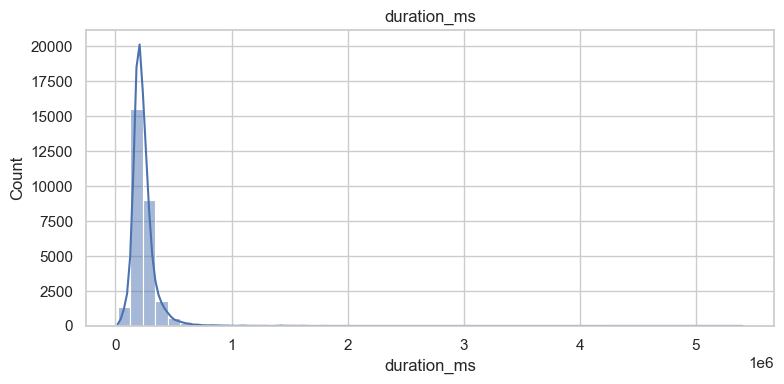

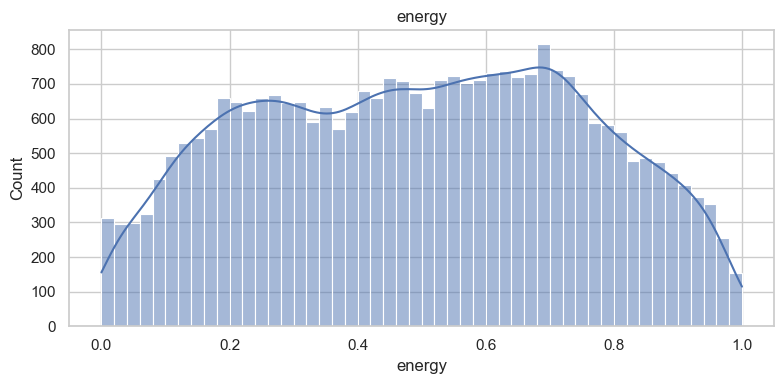

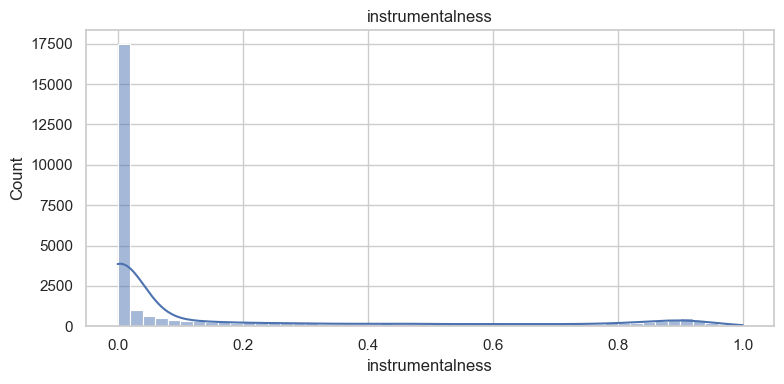

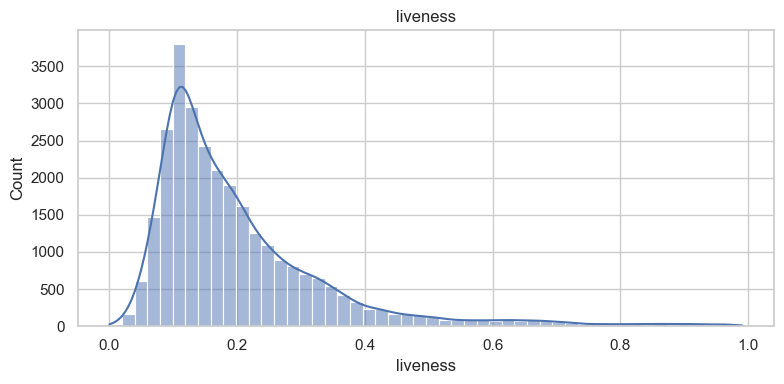

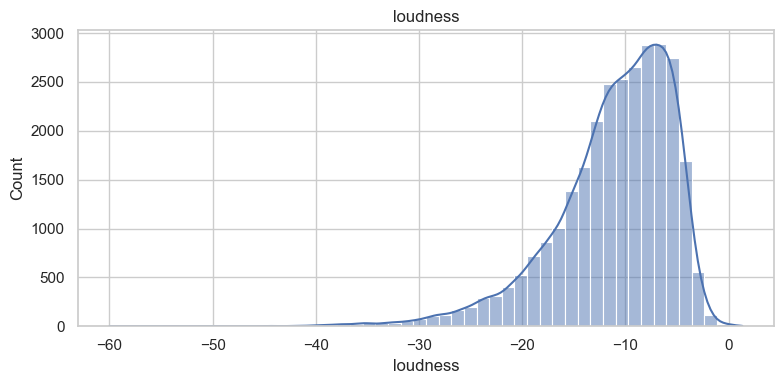

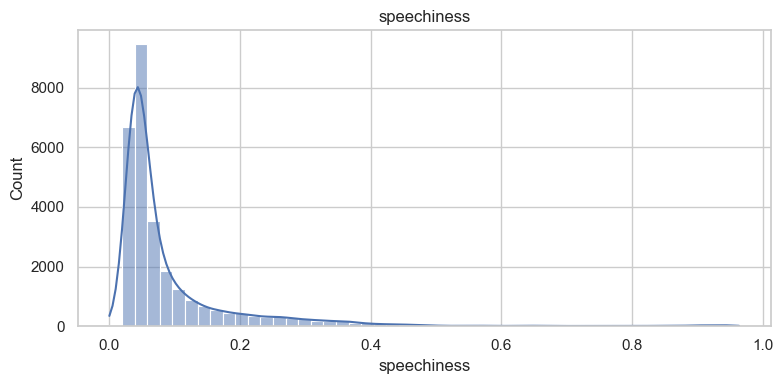

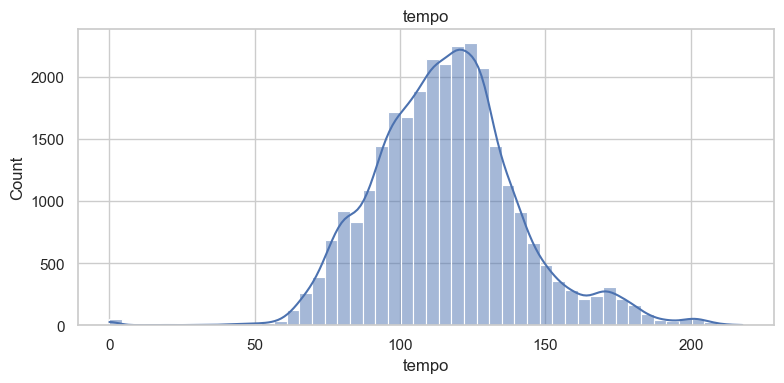

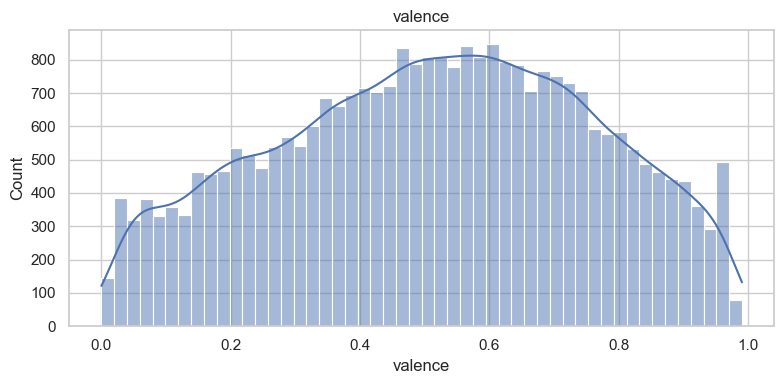

In [ ]:
# Notebook 1: EDA and feature engineering

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Load data
df = pd.read_csv("data_w_genres.csv")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())
print("\nMissing values:")
print(df.isna().sum().sort_values(ascending=False))

# Genre extraction
def extract_main_genre(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().strip("[]").replace("'", "")
    parts = [p.strip() for p in s.split(",") if p.strip()]
    return parts[0] if parts else np.nan

df["main_genre"] = df["genres"].apply(extract_main_genre)

print("\nTop genres:")
print(df["main_genre"].value_counts().head(20))
print("\nTop artists:")
print(df["artists"].value_counts().head(20))

df = df.dropna(subset=["popularity"])

# Feature engineering
df["duration_min"] = df["duration_ms"] / 60000.0
df["is_instrumental"] = (df["instrumentalness"] > 0.8).astype(int)
df["is_acoustic"] = (df["acousticness"] > 0.7).astype(int)
df["main_genre_encoded"] = df["main_genre"].astype("category").cat.codes

engineered_cols = ["duration_min", "is_instrumental", "is_acoustic", "main_genre_encoded"]
print("\nEngineered features:", engineered_cols)

# Numeric feature distributions
numeric_cols = [
    "acousticness", "danceability", "duration_ms", "energy",
    "instrumentalness", "liveness", "loudness", "speechiness",
    "tempo", "valence", "popularity", "key", "mode", "count",
    "duration_min"
]
numeric_cols = [c for c in numeric_cols if c in df.columns]

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col].dropna(), bins=50, kde=True)
    plt.title(col)
    plt.tight_layout()
    plt.show()

# Binary features
for col in ["is_instrumental", "is_acoustic"]:
    if col in df.columns:
        plt.figure(figsize=(4, 4))
        df[col].value_counts().plot(kind="bar")
        plt.title(col)
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()

# Correlation
plt.figure(figsize=(12, 10))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap="coolwarm")
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

if "popularity" in df.columns:
    print("\nCorrelation with popularity:")
    print(corr["popularity"].sort_values(ascending=False))

# Popularity by genre
top_genres = df["main_genre"].value_counts().head(10).index
genre_popularity = (
    df[df["main_genre"].isin(top_genres)]
    .groupby("main_genre")["popularity"]
    .mean()
    .sort_values()
)

plt.figure(figsize=(10, 6))
genre_popularity.plot(kind="barh")
plt.title("Popularity by genre")
plt.tight_layout()
plt.show()

# Popularity by artist
top_artists = df["artists"].value_counts().head(15).index
artist_popularity = (
    df[df["artists"].isin(top_artists)]
    .groupby("artists")["popularity"]
    .mean()
    .sort_values()
)

plt.figure(figsize=(10, 6))
artist_popularity.plot(kind="barh")
plt.title("Popularity by artist")
plt.tight_layout()
plt.show()

# Feature vs popularity
rel_cols = [
    "danceability", "energy", "acousticness", "instrumentalness",
    "loudness", "valence", "tempo", "duration_min"
]
rel_cols = [c for c in rel_cols if c in df.columns]

sample_size = min(8000, len(df))
sample = df.sample(sample_size, random_state=42)

for col in rel_cols:
    plt.figure(figsize=(7, 5))
    sns.scatterplot(data=sample, x=col, y="popularity", alpha=0.25)
    plt.title(f"{col} vs popularity")
    plt.tight_layout()
    plt.show()

# Pairplot
pair_cols = ["danceability", "energy", "acousticness", "valence", "popularity"]
pair_cols = [c for c in pair_cols if c in df.columns]

pair_sample = df[pair_cols].sample(min(2000, len(df)), random_state=42)
sns.pairplot(pair_sample)
plt.show()

# Save cleaned dataset
df.to_csv("data_cleaned.csv", index=False)
print("\nSaved cleaned dataset as data_cleaned.csv")